In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

In [2]:
print(imblearn.__version__)

0.9.1


In [3]:
%store -r final_draftDB

In [4]:
final_draftDB.head()

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP
0,1,Chicago Blackhawks,Patrick Kane,RW,18.0,177.80,178.0,43.0,58.0,101.0,11.27172,29.52000,40.79172,18.24828,1.0,1126.0
1,2,Philadelphia Flyers,James van Riemsdyk,LW,18.0,190.50,200.0,32.0,30.0,62.0,3.78102,12.60094,16.38196,8.81992,1.0,885.0
2,3,Phoenix Coyotes,Kyle Turris,C,18.0,185.42,185.0,57.0,53.0,110.0,8.26560,14.95680,23.22240,6.69120,1.0,776.0
3,4,Los Angeles Kings,Thomas Hickey,D,18.0,180.34,184.0,69.0,68.0,137.0,4.74042,8.55588,13.29630,3.81546,1.0,456.0
4,5,Washington Capitals,Karl Alzner,D,18.0,190.50,206.0,70.0,63.0,133.0,3.93108,8.67150,12.60258,4.74042,1.0,686.0


### Separate target variable

In [5]:
x_db = final_draftDB.drop(['Overall', 'Team', 'Player', 'NHLer'], axis=1)

y_db = final_draftDB['NHLer']

## Train Test Split

In [6]:
X_train = x_db.loc[0:1132]
X_test = x_db.loc[1133:1512]
y_train = y_db.loc[:1132]
y_test = y_db.loc[1133:1512]

In [7]:
X_train.shape

(1133, 12)

In [8]:
X_test.shape

(379, 12)

## Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

### One Hot Encoder

In [10]:
ohe = OneHotEncoder(sparse=False)

### Instantiate PCA for categorical variables

In [11]:
# Select number of principle components
pca = PCA(n_components=1)

### Instantiate SelectKbest for numeric variables

In [12]:
# Instantiate SelectKBest Variable
selection = SelectKBest(k=6)

### Instantiate Standard Scaler for numeric variables

In [13]:
scaler=StandardScaler()

### Set up classifiers

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
from sklearn.ensemble import GradientBoostingClassifier


Gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=4)

### Set up pipeline

In [16]:
# define individual transformers in a pipeline

categorical_preprocessing = Pipeline([('ohe', OneHotEncoder(sparse=False)),
                                     ('PCA', pca)])

numerical_preprocessing = Pipeline([('scale', StandardScaler()),
                                   ('selectK_best', selection)])

In [17]:
preprocess = ColumnTransformer([
    ('categorical_preprocessing', categorical_preprocessing, ['Pos']),
    ('numerical_preprocessing', numerical_preprocessing, ['Age', 'Height', 'Weight',
                                                          'D-1_GP', 'D0_GP',
                                                          'Total GP', 'D-1_NHLe',
                                                          'D0_NHLe', 'NHLe Total',
                                                          'NHLe Progression'
                                                         ])
])
    
preprocess

ColumnTransformer(transformers=[('categorical_preprocessing',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(sparse=False)),
                                                 ('PCA', PCA(n_components=1))]),
                                 ['Pos']),
                                ('numerical_preprocessing',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('selectK_best',
                                                  SelectKBest(k=6))]),
                                 ['Age', 'Height', 'Weight', 'D-1_GP', 'D0_GP',
                                  'Total GP', 'D-1_NHLe', 'D0_NHLe',
                                  'NHLe Total', 'NHLe Progression'])])

In [18]:
# create the final pipeline with preprocessing steps and 
# the final classifier step
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('best_model', Gb_clf)
])

pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False)),
                                                                  ('PCA',
                                                                   PCA(n_components=1))]),
                                                  ['Pos']),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('selectK_best',
                                                                   SelectKBest(k=6))]),
                                                  ['Age', 'Height', 'Weight',
                                                   'D-1_GP', 'D0_GP',
                                                   'Total GP', 'D-1_NHLe',
                                                   'D0_NHLe', 'NHLe Total',
                                                   'NHLe Progression'])])),
                ('best_model',
                 GradientBoostingClassifier(max_depth=4, n_estimators=10))])

In [19]:
# Call the pipeline on the training data

xgb_model = pipeline.fit(X_train, y_train)

In [20]:
xgb_model.score(X_test, y_test)

0.7941952506596306

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = xgb_model.predict(X_test)

print(f' The F1 score is :', f1_score(y_test, y_pred))
print(f' The precision score is :', precision_score(y_test, y_pred))
print(f' The recall score is :', recall_score(y_test, y_pred))

 The F1 score is : 0.2352941176470588
 The precision score is : 0.8
 The recall score is : 0.13793103448275862


In [22]:
feat_names = pipeline.steps[0][1].get_feature_names_out()
feat_import = pipeline.steps[1][1].feature_importances_

<AxesSubplot: >

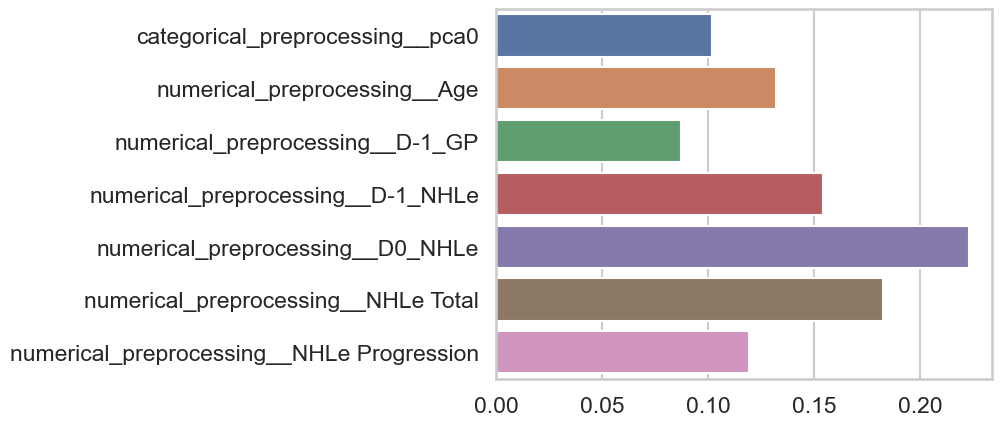

In [23]:
sns.set_theme(style='whitegrid', context='talk')

sns.set_color_codes('pastel')
sns.barplot(x=feat_import, y=feat_names)

### Using Gridsearch for hyperparameter tuning

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = [
    {
        'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
        'best_model__n_estimators': [10, 100, 250],
        'best_model__max_depth': [3, 4, 5]
    }
]

In [26]:
gridSearch = GridSearchCV(xgb_model, param_grid=param_grid, n_jobs=-1, verbose=3)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('categorical_preprocessing',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(sparse=False)),
                                                                                         ('PCA',
                                                                                          PCA(n_components=1))]),
                                                                         ['Pos']),
                                                                        ('numerical_preprocessing',
                                                                         Pipeline(steps=[('scale',
                                                                                          StandardScaler()),
                                                                                         ('selectK_best',
                                                                                          SelectKBest(k=6))]),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'D-1_GP',
                                                                          'D0_GP',
                                                                          'Total '
                                                                          'GP',
                                                                          'D-1_NHLe',
                                                                          'D0_NHLe',
                                                                          'NHLe '
                                                                          'Total',
                                                                          'NHLe '
                                                                          'Progression'])])),
                                       ('best_model',
                                        GradientBoostingClassifier(max_depth=4,
                                                                   n_estimators=10))]),
             n_jobs=-1,
             param_grid=[{'best_model__learning_rate': [0.001, 0.01, 0.1, 1.0],
                          'best_model__max_depth': [3, 4, 5],
                          'best_model__n_estimators': [10, 100, 250]}],
             verbose=3)

In [27]:
print('Final score is: ', gridSearch.score(X_test, y_test))

Final score is:  0.8073878627968337


In [28]:
gridSearch.predict(X_test)

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [29]:
y_pred = gridSearch.predict(X_test)

print(f' The F1 score is :', f1_score(y_test, y_pred))
print(f' The precision score is :', precision_score(y_test, y_pred))
print(f' The recall score is :', recall_score(y_test, y_pred))

 The F1 score is : 0.3760683760683761
 The precision score is : 0.7333333333333333
 The recall score is : 0.25287356321839083


In [30]:
gridSearch.best_params_

{'best_model__learning_rate': 0.01,
 'best_model__max_depth': 4,
 'best_model__n_estimators': 250}

### Recreate NHLer probability dataframe

In [31]:
NHLer_probability = []

for player in range(len(pipeline.predict_proba(X_test))):
    NHLer_probability.append((pipeline.predict_proba(X_test)[player][1]))

In [32]:
X_test['NHL probability'] = NHLer_probability

/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_10465/3858701887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['NHL probability'] = NHLer_probability


In [33]:
X_test['Player'] = final_draftDB.loc[1133:1512]['Player']
X_test['Overall'] = final_draftDB.loc[1133:1512]['Overall']

/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_10465/811153666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Player'] = final_draftDB.loc[1133:1512]['Player']
/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_10465/811153666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Overall'] = final_draftDB.loc[1133:1512]['Overall']


In [34]:
X_test.loc[1133:1322].sort_values('NHL probability', ascending=False).head(60)

,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,GP,NHL probability,Player,Overall
1134,C,18.0,198.12,209.0,32.0,53.0,85.0,18.08100,32.90742,50.98842,14.82642,615.0,0.700530,Aleksander Barkov,2
1137,C,18.0,198.12,192.0,36.0,48.0,84.0,2.67648,29.23956,31.91604,26.56308,682.0,0.598199,Elias Lindholm,5
1138,C,18.0,198.12,187.0,62.0,58.0,120.0,14.87808,15.82272,30.70080,0.94464,676.0,0.574090,Sean Monahan,6
1174,C,18.0,172.72,165.0,61.0,71.0,132.0,6.59034,19.53978,26.13012,12.94944,156.0,0.565547,Nic Petan,43
1133,C,18.0,198.12,182.0,58.0,44.0,102.0,12.41644,15.75220,28.16864,3.33576,656.0,0.544774,Nathan MacKinnon,1
1203,C,18.0,175.26,157.0,31.0,60.0,91.0,4.76256,14.30572,19.06828,9.54316,391.0,0.543326,Jake Guentzel,77
1144,LW,18.0,165.10,197.0,62.0,64.0,126.0,9.32832,16.05888,25.38720,6.73056,520.0,0.506413,Max Domi,12
1146,C,18.0,198.12,190.0,42.0,46.0,88.0,0.88560,20.14740,21.03300,19.26180,570.0,0.489817,Alexander Wennberg,14
1151,LW,18.0,198.12,205.0,68.0,68.0,136.0,12.87072,15.11424,27.98496,2.24352,43.0,0.485385,Kerby Rychel,19
1184,LW,18.0,180.34,163.0,40.0,45.0,85.0,9.18810,24.22854,33.41664,15.04044,430.0,0.476685,Artturi Lehkonen,55


In [35]:
X_test.loc[1323:1512].sort_values('NHL probability', ascending=False).head(60)

,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,GP,NHL probability,Player,Overall
1325,C,18.0,185.42,204.0,64.0,64.0,128.0,10.52142,18.96168,29.48310,8.44026,578.0,0.594521,Leon Draisaitl,3
1324,C,18.0,182.88,190.0,72.0,60.0,132.0,13.64316,20.23350,33.87666,6.59034,552.0,0.594521,Sam Reinhart,2
1393,C,18.0,175.26,160.0,67.0,72.0,139.0,9.82770,14.56812,24.39582,4.74042,436.0,0.574090,Brayden Point,79
1326,C,18.0,182.88,178.0,60.0,57.0,117.0,7.91136,18.89280,26.80416,10.98144,503.0,0.565547,Samuel Bennett,4
1343,C,18.0,177.80,170.0,59.0,58.0,117.0,6.61248,17.71200,24.32448,11.09952,302.0,0.565547,Robert Fabbri,21
1327,LW,18.0,185.42,182.0,63.0,67.0,130.0,8.97408,16.76736,25.74144,7.79328,112.0,0.506413,Michael Dal Colle,5
1350,RW,18.0,180.34,175.0,63.0,67.0,130.0,8.26560,14.99616,23.26176,6.73056,53.0,0.506413,Joshua Ho-Sang,28
1341,D,18.0,177.80,175.0,62.0,51.0,113.0,11.09952,16.41312,27.51264,5.31360,290.0,0.504546,Anthony Deangelo,19
1334,LW,18.0,187.96,205.0,59.0,58.0,117.0,2.36160,14.40576,16.76736,12.04416,262.0,0.487744,Brendan Perlini,12
1349,RW,18.0,180.34,178.0,68.0,67.0,135.0,11.80800,16.53120,28.33920,4.72320,125.0,0.485385,Nikolay Goldobin,27


In [36]:
NHLer_proba = []

for player in range(len(pipeline.predict_proba(X_train))):
    NHLer_proba.append((pipeline.predict_proba(X_train)[player][1]))

In [37]:
X_train['NHL probability'] = NHLer_proba

/var/folders/cl/dg9768bj6ys0prn_4p_bbftw0000gn/T/ipykernel_10465/3335992729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['NHL probability'] = NHLer_proba


In [38]:
# Concatenate the train and test data with the NHLer probabilities

NHLer_db = pd.concat([X_train, X_test], axis=0)

In [39]:
# Re-sort the index to match the original dataframe

NHLer_db.sort_index(inplace=True)

In [40]:
# Create column in the original dataframe called "NHLer probabilities"

final_draftDB['NHL probability'] = NHLer_db['NHL probability']

### Mock drafts

In [41]:
# Re-create the 2007 draft with the NHLe and NHLer probabilities

mock_2007=final_draftDB.loc[:189]

In [42]:
mock_2007.sort_values('NHL probability', ascending=False).head(50)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
8,9,San Jose Sharks,Logan Couture,C,18.0,185.42,195.0,65.0,54.0,119.0,11.57184,17.00352,28.57536,5.43168,1.0,867.0,0.574090
2,3,Phoenix Coyotes,Kyle Turris,C,18.0,185.42,185.0,57.0,53.0,110.0,8.26560,14.95680,23.22240,6.69120,1.0,776.0,0.565547
5,6,Edmonton Oilers,Sam Gagner,C,18.0,180.34,191.0,56.0,53.0,109.0,9.61532,26.33184,35.94716,16.71652,1.0,985.0,0.565547
7,8,Boston Bruins,Zach Hamill,C,18.0,180.34,180.0,53.0,69.0,122.0,12.83382,15.60870,28.44252,2.77488,0.0,20.0,0.544774
0,1,Chicago Blackhawks,Patrick Kane,RW,18.0,177.80,178.0,43.0,58.0,101.0,11.27172,29.52000,40.79172,18.24828,1.0,1126.0,0.515962
43,45,Colorado Avalanche,Colby Cohen,D,18.0,187.96,200.0,28.0,53.0,81.0,1.78350,13.25038,15.03388,11.46688,0.0,3.0,0.472666
31,32,Phoenix Coyotes,Brett Maclean,LW,18.0,185.42,200.0,48.0,68.0,116.0,11.33568,17.35776,28.69344,6.02208,0.0,18.0,0.455752
41,43,Montreal Canadiens,P.K. Subban,D,18.0,182.88,206.0,52.0,68.0,120.0,2.71584,9.68256,12.39840,6.96672,1.0,834.0,0.455054
17,18,St. Louis Blues,Ian Cole,D,18.0,185.42,221.0,19.0,42.0,61.0,1.14144,4.06802,5.20946,2.92658,1.0,686.0,0.432836
69,74,Toronto Maple Leafs,Dale Mitchell,RW,18.0,175.26,200.0,65.0,67.0,132.0,7.79328,14.05152,21.84480,6.25824,0.0,NaN,0.429274


In [43]:
mock_2008=final_draftDB.loc[190:377]
mock_2008.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
190,1,Tampa Bay Lightning,Steven Stamkos,C,18.0,185.42,188.0,63.0,61.0,124.0,17.23968,20.30976,37.54944,3.07008,1.0,942.0,0.652072
198,9,New York Islanders,Josh Bailey,C,18.0,185.42,201.0,69.0,67.0,136.0,10.39104,16.88544,27.27648,6.49440,1.0,1013.0,0.594521
199,10,Vancouver Canucks,Cody Hodgson,C,18.0,182.88,185.0,63.0,68.0,131.0,8.61984,14.76000,23.37984,6.14016,1.0,328.0,0.594521
196,7,Nashville Predators,Colin Wilson,C,18.0,185.42,214.0,41.0,44.0,85.0,8.70348,18.13512,26.83860,9.43164,1.0,632.0,0.565547
214,26,Buffalo Sabres,Tyler Ennis,C,18.0,175.26,157.0,71.0,70.0,141.0,8.09340,15.03060,23.12400,6.93720,1.0,700.0,0.518048
192,3,Atlanta Thrashers,Zach Bogosian,D,18.0,190.50,215.0,67.0,60.0,127.0,5.78592,12.04416,17.83008,6.25824,1.0,740.0,0.518012
208,20,New York Rangers,Michael Del Zotto,D,18.0,182.88,193.0,64.0,64.0,128.0,10.50912,11.57184,22.08096,1.06272,1.0,736.0,0.516146
303,128,Toronto Maple Leafs,Greg Pateryn,D,18.0,187.96,212.0,27.0,60.0,87.0,2.38784,5.27670,7.66454,2.88886,1.0,290.0,0.515950
191,2,Los Angeles Kings,Drew Doughty,D,18.0,182.88,212.0,67.0,58.0,125.0,12.98880,10.15488,23.14368,-2.83392,1.0,1038.0,0.494426
197,8,Phoenix Coyotes,Mikkel Boedker,RW,18.0,180.34,202.0,39.0,62.0,101.0,2.47968,13.93344,16.41312,11.45376,1.0,709.0,0.487744


In [44]:
final_draftDB.loc[378:566]

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
378,1,New York Islanders,John Tavares,C,18.0,182.88,183.0,59.0,56.0,115.0,23.61600,21.96288,45.57888,-1.65312,1.0,972.0,0.660692
379,2,Tampa Bay Lightning,Victor Hedman,D,18.0,200.66,229.0,39.0,43.0,82.0,4.64120,22.74188,27.38308,18.10068,1.0,916.0,0.476685
380,3,Colorado Avalanche,Matt Duchene,C,18.0,180.34,190.0,64.0,57.0,121.0,9.21024,16.41312,25.62336,7.20288,1.0,925.0,0.594521
381,4,Atlanta Thrashers,Evander Kane,LW,18.0,180.34,168.0,65.0,61.0,126.0,7.28406,18.15234,25.43640,10.86828,1.0,826.0,0.506413
382,5,Los Angeles Kings,Brayden Schenn,C,18.0,185.42,195.0,66.0,70.0,136.0,12.48696,14.56812,27.05508,2.08116,1.0,797.0,0.574090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,206,Boston Bruins,Ben Sexton,C,18.0,180.34,182.0,48.0,38.0,86.0,2.47968,3.62112,6.10080,1.14144,0.0,2.0,0.248667
563,207,San Jose Sharks,Dominik Bielke,D,18.0,190.50,190.0,46.0,7.0,53.0,1.81220,0.00000,1.81220,-1.81220,0.0,NaN,0.112988
564,208,Carolina Hurricanes,Tommi Kivisto,D,18.0,187.96,194.0,26.0,65.0,91.0,2.03360,3.93108,5.96468,1.89748,0.0,NaN,0.276754
565,209,Chicago Blackhawks,David Gilbert,C,18.0,182.88,171.0,28.0,67.0,95.0,4.63300,5.93024,10.56324,1.29724,0.0,NaN,0.275926


In [45]:
mock_2009=final_draftDB.loc[378:566]
mock_2009.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
378,1,New York Islanders,John Tavares,C,18.0,182.88,183.0,59.0,56.0,115.0,23.61600,21.96288,45.57888,-1.65312,1.0,972.0,0.660692
380,3,Colorado Avalanche,Matt Duchene,C,18.0,180.34,190.0,64.0,57.0,121.0,9.21024,16.41312,25.62336,7.20288,1.0,925.0,0.594521
382,5,Los Angeles Kings,Brayden Schenn,C,18.0,185.42,195.0,66.0,70.0,136.0,12.48696,14.56812,27.05508,2.08116,1.0,797.0,0.574090
384,7,Toronto Maple Leafs,Nazem Kadri,C,18.0,182.88,182.0,68.0,56.0,124.0,11.33568,16.41312,27.74880,5.07744,1.0,760.0,0.574090
399,22,Vancouver Canucks,Jordan Schroeder,C,18.0,177.80,175.0,41.0,35.0,76.0,7.63338,20.52132,28.15470,12.88794,0.0,165.0,0.565547
383,6,Phoenix Coyotes,Oliver Ekman-Larsson,D,18.0,182.88,182.0,27.0,39.0,66.0,2.68140,12.66408,15.34548,9.98268,1.0,870.0,0.541727
389,12,New York Islanders,Calvin de Haan,D,18.0,182.88,173.0,58.0,68.0,126.0,2.83392,10.98144,13.81536,8.14752,1.0,535.0,0.541727
387,10,Edmonton Oilers,Magnus Paajarvi,LW,18.0,180.34,180.0,18.0,50.0,68.0,2.40096,15.78008,18.18104,13.37912,1.0,467.0,0.520515
397,20,New Jersey Devils,Jacob Josefson,C,18.0,182.88,183.0,34.0,50.0,84.0,1.79088,14.85184,16.64272,13.06096,1.0,315.0,0.507814
388,11,Nashville Predators,Ryan Ellis,D,18.0,180.34,180.0,63.0,57.0,120.0,11.80800,18.42048,30.22848,6.61248,1.0,566.0,0.506413


In [46]:
mock_2010=final_draftDB.loc[567:755]
mock_2010.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
581,16,St. Louis Blues,Vladimir Tarasenko,RW,18.0,182.88,185.0,38.0,42.0,80.0,16.45904,36.08328,52.54232,19.62424,1.0,623.0,0.620764
567,1,Edmonton Oilers,Taylor Hall,LW,18.0,182.88,180.0,63.0,57.0,120.0,16.88544,21.96288,38.84832,5.07744,1.0,781.0,0.605474
575,9,Minnesota Wild,Mikael Granlund,C,18.0,175.26,160.0,35.0,43.0,78.0,11.09378,33.63066,44.72444,22.53688,1.0,691.0,0.603699
573,7,Carolina Hurricanes,Jeff Skinner,C,18.0,177.80,197.0,63.0,64.0,127.0,9.56448,16.64928,26.21376,7.08480,1.0,873.0,0.594521
632,70,Los Angeles Kings,Jordan Weal,C,18.0,172.72,156.0,65.0,72.0,137.0,12.48696,16.41804,28.90500,3.93108,1.0,218.0,0.574090
568,2,Boston Bruins,Tyler Seguin,C,18.0,182.88,170.0,61.0,63.0,124.0,12.98880,19.83744,32.82624,6.84864,1.0,845.0,0.565547
579,14,St. Louis Blues,Jaden Schwartz,C,18.0,177.80,180.0,46.0,60.0,106.0,7.03560,16.18188,23.21748,9.14628,1.0,616.0,0.565547
591,26,Washington Capitals,Evgeny Kuznetsov,C,18.0,180.34,170.0,21.0,35.0,56.0,8.32546,14.55992,22.88538,6.23446,1.0,619.0,0.550665
611,47,Los Angeles Kings,Tyler Toffoli,C,18.0,182.88,181.0,54.0,65.0,119.0,10.03680,14.40576,24.44256,4.36896,1.0,670.0,0.544774
624,62,Toronto Maple Leafs,Greg McKegg,C,18.0,182.88,185.0,64.0,67.0,131.0,3.30624,14.99616,18.30240,11.68992,1.0,233.0,0.543326


In [47]:
mock_2011=final_draftDB.loc[756:946]
mock_2011.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
759,4,New Jersey Devils,Adam Larsson,D,18.0,190.50,197.0,49.0,37.0,86.0,16.24420,11.13888,27.38308,-5.10532,1.0,704.0,0.609482
756,1,Edmonton Oilers,Ryan Nugent-Hopkins,C,18.0,182.88,171.0,67.0,69.0,136.0,11.21514,17.80548,29.02062,6.59034,1.0,739.0,0.594521
761,6,Ottawa Senators,Mika Zibanejad,C,18.0,187.96,195.0,14.0,26.0,40.0,3.40054,16.24420,19.64474,12.84366,1.0,706.0,0.575634
763,8,Philadelphia Flyers,Sean Couturier,C,18.0,190.50,197.0,68.0,58.0,126.0,13.06506,15.38156,28.44662,2.31650,1.0,721.0,0.574090
760,5,New York Islanders,Ryan Strome,C,18.0,182.88,177.0,61.0,65.0,126.0,5.19552,19.24704,24.44256,14.05152,1.0,641.0,0.565547
813,61,Ottawa Senators,Shane Prince,C,18.0,177.80,181.0,65.0,59.0,124.0,5.43168,17.59392,23.02560,12.16224,0.0,128.0,0.518048
758,3,Florida Panthers,Jonathan Huberdeau,C,18.0,185.42,171.0,61.0,67.0,128.0,5.28162,14.54762,19.82924,9.26600,1.0,687.0,0.518048
764,9,Boston Bruins,Dougie Hamilton,D,18.0,195.58,193.0,64.0,67.0,131.0,2.95200,10.27296,13.22496,7.32096,1.0,689.0,0.490074
779,24,Ottawa Senators,Matt Puempel,LW,18.0,182.88,198.0,59.0,55.0,114.0,12.75264,14.76000,27.51264,2.00736,0.0,87.0,0.455752
757,2,Colorado Avalanche,Gabriel Landeskog,LW,18.0,185.42,204.0,61.0,53.0,114.0,8.85600,14.76000,23.61600,5.90400,1.0,738.0,0.455752


In [48]:
mock_2012=final_draftDB.loc[947:1132]
mock_2012.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
947,1,Edmonton Oilers,Nail Yakupov,RW,18.0,180.34,185.0,65.0,42.0,107.0,18.30240,19.36512,37.66752,1.06272,1.0,350.0,0.605474
963,17,San Jose Sharks,Tomas Hertl,C,18.0,187.96,198.0,33.0,38.0,71.0,7.52432,31.55196,39.07628,24.02764,1.0,607.0,0.603699
1089,158,Minnesota Wild,Christoph Bertschy,C,18.0,177.80,170.0,36.0,31.0,67.0,3.57602,19.57176,23.14778,15.99574,0.0,9.0,0.543326
951,5,Toronto Maple Leafs,Morgan Rielly,D,18.0,182.88,200.0,65.0,18.0,83.0,4.97166,11.56200,16.53366,6.59034,1.0,674.0,0.518012
961,15,Ottawa Senators,Cody Ceci,D,18.0,185.42,205.0,68.0,64.0,132.0,5.90400,11.09952,17.00352,5.19552,1.0,647.0,0.516146
1055,121,Los Angeles Kings,Nikolai Prokhorkin,LW,18.0,187.96,190.0,46.0,15.0,61.0,10.20162,20.28598,30.48760,10.08436,0.0,43.0,0.476685
964,18,Chicago Blackhawks,Teuvo Teravainen,LW,18.0,177.80,169.0,26.0,40.0,66.0,5.24062,16.27290,21.51352,11.03228,1.0,540.0,0.461657
952,6,Anaheim Ducks,Hampus Lindholm,D,18.0,190.50,195.0,39.0,28.0,67.0,0.19680,1.20048,1.39728,1.00368,1.0,611.0,0.456237
953,7,Minnesota Wild,Mathew Dumba,D,18.0,180.34,184.0,62.0,69.0,131.0,4.85604,9.59646,14.45250,4.74042,1.0,538.0,0.420188
948,2,Columbus Blue Jackets,Ryan Murray,D,18.0,182.88,198.0,70.0,46.0,116.0,7.63092,7.74654,15.37746,0.11562,1.0,445.0,0.413869


In [49]:
mock_2013=final_draftDB.loc[1133:1322]
mock_2013.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
1134,2,Florida Panthers,Aleksander Barkov,C,18.0,198.12,209.0,32.0,53.0,85.0,18.08100,32.90742,50.98842,14.82642,1.0,615.0,0.700530
1137,5,Carolina Hurricanes,Elias Lindholm,C,18.0,198.12,192.0,36.0,48.0,84.0,2.67648,29.23956,31.91604,26.56308,1.0,682.0,0.598199
1138,6,Calgary Flames,Sean Monahan,C,18.0,198.12,187.0,62.0,58.0,120.0,14.87808,15.82272,30.70080,0.94464,1.0,676.0,0.574090
1174,43,Winnipeg Jets,Nic Petan,C,18.0,172.72,165.0,61.0,71.0,132.0,6.59034,19.53978,26.13012,12.94944,0.0,156.0,0.565547
1133,1,Colorado Avalanche,Nathan MacKinnon,C,18.0,198.12,182.0,58.0,44.0,102.0,12.41644,15.75220,28.16864,3.33576,1.0,656.0,0.544774
1203,77,Pittsburgh Penguins,Jake Guentzel,C,18.0,175.26,157.0,31.0,60.0,91.0,4.76256,14.30572,19.06828,9.54316,1.0,391.0,0.543326
1144,12,Phoenix Coyotes,Max Domi,LW,18.0,165.10,197.0,62.0,64.0,126.0,9.32832,16.05888,25.38720,6.73056,1.0,520.0,0.506413
1146,14,Columbus Blue Jackets,Alexander Wennberg,C,18.0,198.12,190.0,42.0,46.0,88.0,0.88560,20.14740,21.03300,19.26180,1.0,570.0,0.489817
1151,19,Columbus Blue Jackets,Kerby Rychel,LW,18.0,198.12,205.0,68.0,68.0,136.0,12.87072,15.11424,27.98496,2.24352,0.0,43.0,0.485385
1184,55,Montreal Canadiens,Artturi Lehkonen,LW,18.0,180.34,163.0,40.0,45.0,85.0,9.18810,24.22854,33.41664,15.04044,1.0,430.0,0.476685


In [50]:
mock_2014=final_draftDB.loc[1323:1512]
mock_2014.sort_values('NHL probability', ascending=False).head(60)

,Overall,Team,Player,Pos,Age,Height,Weight,D-1_GP,D0_GP,Total GP,D-1_NHLe,D0_NHLe,NHLe Total,NHLe Progression,NHLer,GP,NHL probability
1325,3,Edmonton Oilers,Leon Draisaitl,C,18.0,185.42,204.0,64.0,64.0,128.0,10.52142,18.96168,29.48310,8.44026,1.0,578.0,0.594521
1324,2,Buffalo Sabres,Sam Reinhart,C,18.0,182.88,190.0,72.0,60.0,132.0,13.64316,20.23350,33.87666,6.59034,1.0,552.0,0.594521
1393,79,Tampa Bay Lightning,Brayden Point,C,18.0,175.26,160.0,67.0,72.0,139.0,9.82770,14.56812,24.39582,4.74042,1.0,436.0,0.574090
1326,4,Calgary Flames,Samuel Bennett,C,18.0,182.88,178.0,60.0,57.0,117.0,7.91136,18.89280,26.80416,10.98144,1.0,503.0,0.565547
1343,21,St. Louis Blues,Robert Fabbri,C,18.0,177.80,170.0,59.0,58.0,117.0,6.61248,17.71200,24.32448,11.09952,1.0,302.0,0.565547
1327,5,New York Islanders,Michael Dal Colle,LW,18.0,185.42,182.0,63.0,67.0,130.0,8.97408,16.76736,25.74144,7.79328,0.0,112.0,0.506413
1350,28,New York Islanders,Joshua Ho-Sang,RW,18.0,180.34,175.0,63.0,67.0,130.0,8.26560,14.99616,23.26176,6.73056,0.0,53.0,0.506413
1341,19,Tampa Bay Lightning,Anthony Deangelo,D,18.0,177.80,175.0,62.0,51.0,113.0,11.09952,16.41312,27.51264,5.31360,1.0,290.0,0.504546
1334,12,Pheonix Coyotes,Brendan Perlini,LW,18.0,187.96,205.0,59.0,58.0,117.0,2.36160,14.40576,16.76736,12.04416,1.0,262.0,0.487744
1349,27,San Jose Sharks,Nikolay Goldobin,RW,18.0,180.34,178.0,68.0,67.0,135.0,11.80800,16.53120,28.33920,4.72320,0.0,125.0,0.485385


In [51]:
%store -r team_count

In [52]:
team_count.groupby('Team').agg({'GP':'sum'}).sort_values('GP', ascending=False)

,GP
Team,
Los Angeles Kings,11306.0
New York Islanders,10307.0
Anaheim Ducks,9520.0
Tampa Bay Lightning,9420.0
Buffalo Sabres,9151.0
Florida Panthers,9014.0
Ottawa Senators,8983.0
Edmonton Oilers,8666.0
St. Louis Blues,8409.0
